In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bigmart-sales-data/Train.csv
/kaggle/input/bigmart-sales-data/Test.csv


# Import Needed Libraries

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics
from warnings import filterwarnings
filterwarnings('ignore')

# data collection and analysis

In [3]:
#Read the data
df = pd.read_csv("/kaggle/input/bigmart-sales-data/Train.csv")

In [4]:
#See first
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
#  number of data points & data features
df.shape

(8523, 12)

In [6]:
# getting some informations about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [7]:
#  checking the missing values
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

# Handling the missing values

In [8]:
# mean value of "Item_Weight" column
df["Item_Weight"].mean()

12.857645184135976

In [9]:
#  fill the missing values in "Item_Weight" column with "Mean" value
df["Item_Weight"].fillna(df["Item_Weight"].mean(),inplace = True )

# Replace the missing values in "Outlet_Size" with Mode

In [10]:
mode_of_outlet_size = df.pivot_table(values = "Outlet_Size", columns = "Outlet_Type", aggfunc=(lambda x:x.mode()[0]))

In [11]:
mode_of_outlet_size

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [12]:
missing_values = df["Outlet_Size"].isnull()

In [13]:
missing_values 

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool

In [14]:
df.loc[missing_values,'Outlet_Size'] = df.loc[missing_values,'Outlet_Size'].apply(lambda x : mode_of_outlet_size)

In [15]:
# checking for missing value
df.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

# Data Analysis

In [16]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


# Numerical Features

In [17]:
sns.set()

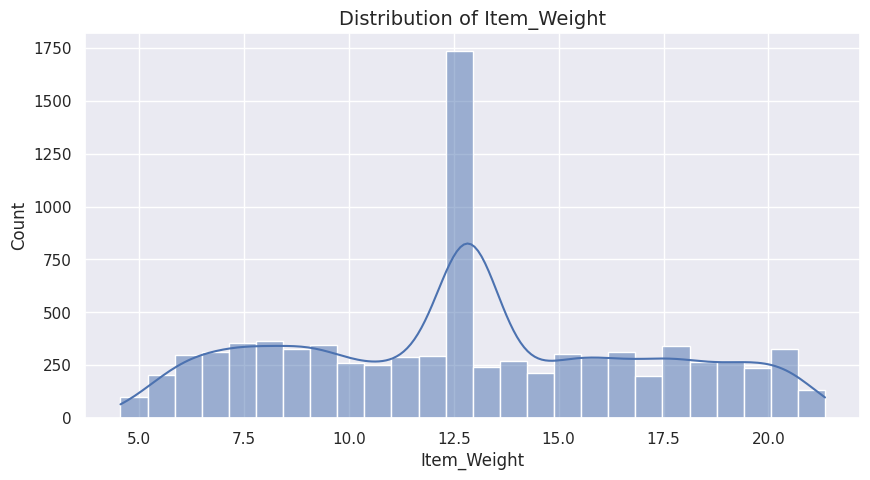

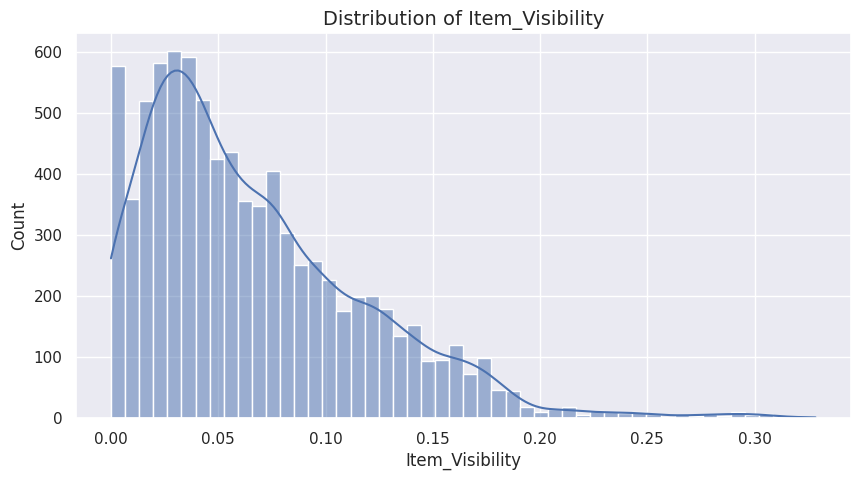

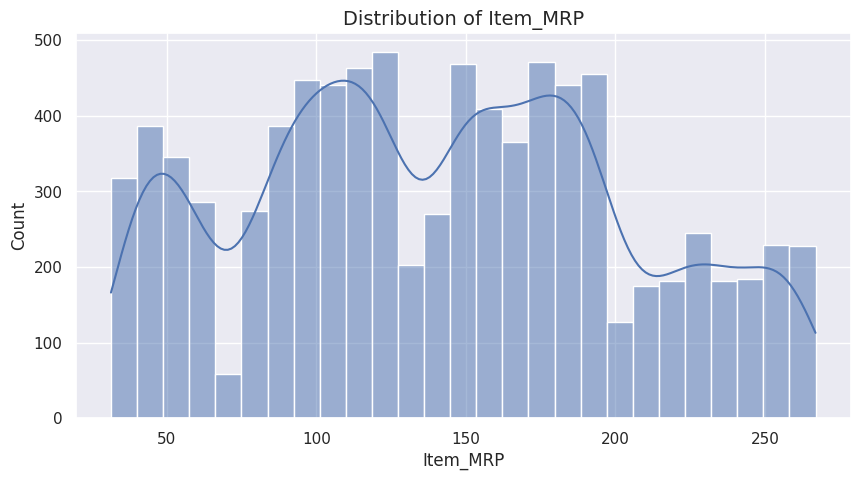

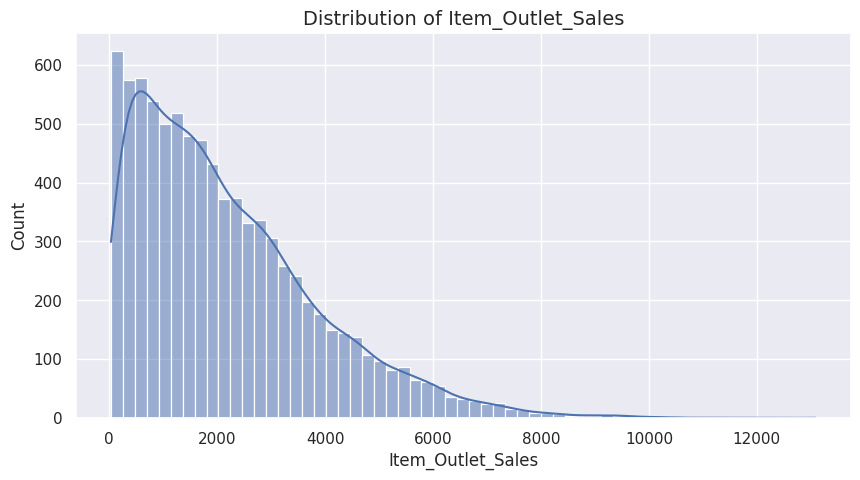

In [18]:
#Plot distplot for numerical columns
cols = ['Item_Weight','Item_Visibility','Item_MRP','Item_Outlet_Sales']
for col in cols:
    plt.figure(figsize=(10,5))
    sns.histplot(df[col], kde=True)  # kde=True adds the kernel density estimate (KDE)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.show()

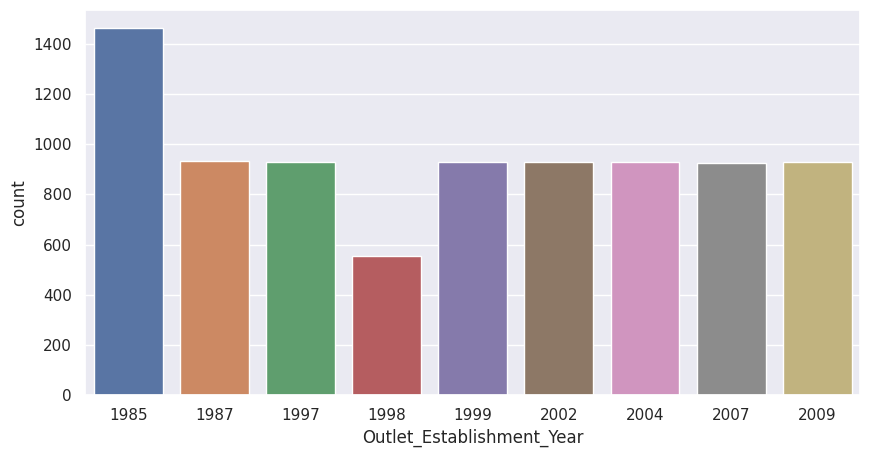

In [19]:
#Plot countplot for Outlet_Establishment_Year column
plt.figure(figsize=(10,5))
sns.countplot(x = "Outlet_Establishment_Year", data = df)
plt.show()

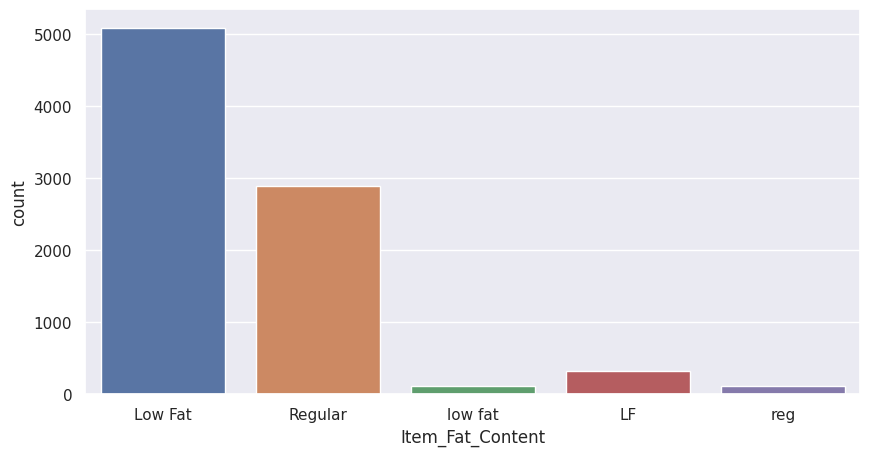

In [20]:
#Plot countplot for Item_Fat_Content column
plt.figure(figsize=(10,5))
sns.countplot(x = "Item_Fat_Content",data = df)
plt.show()

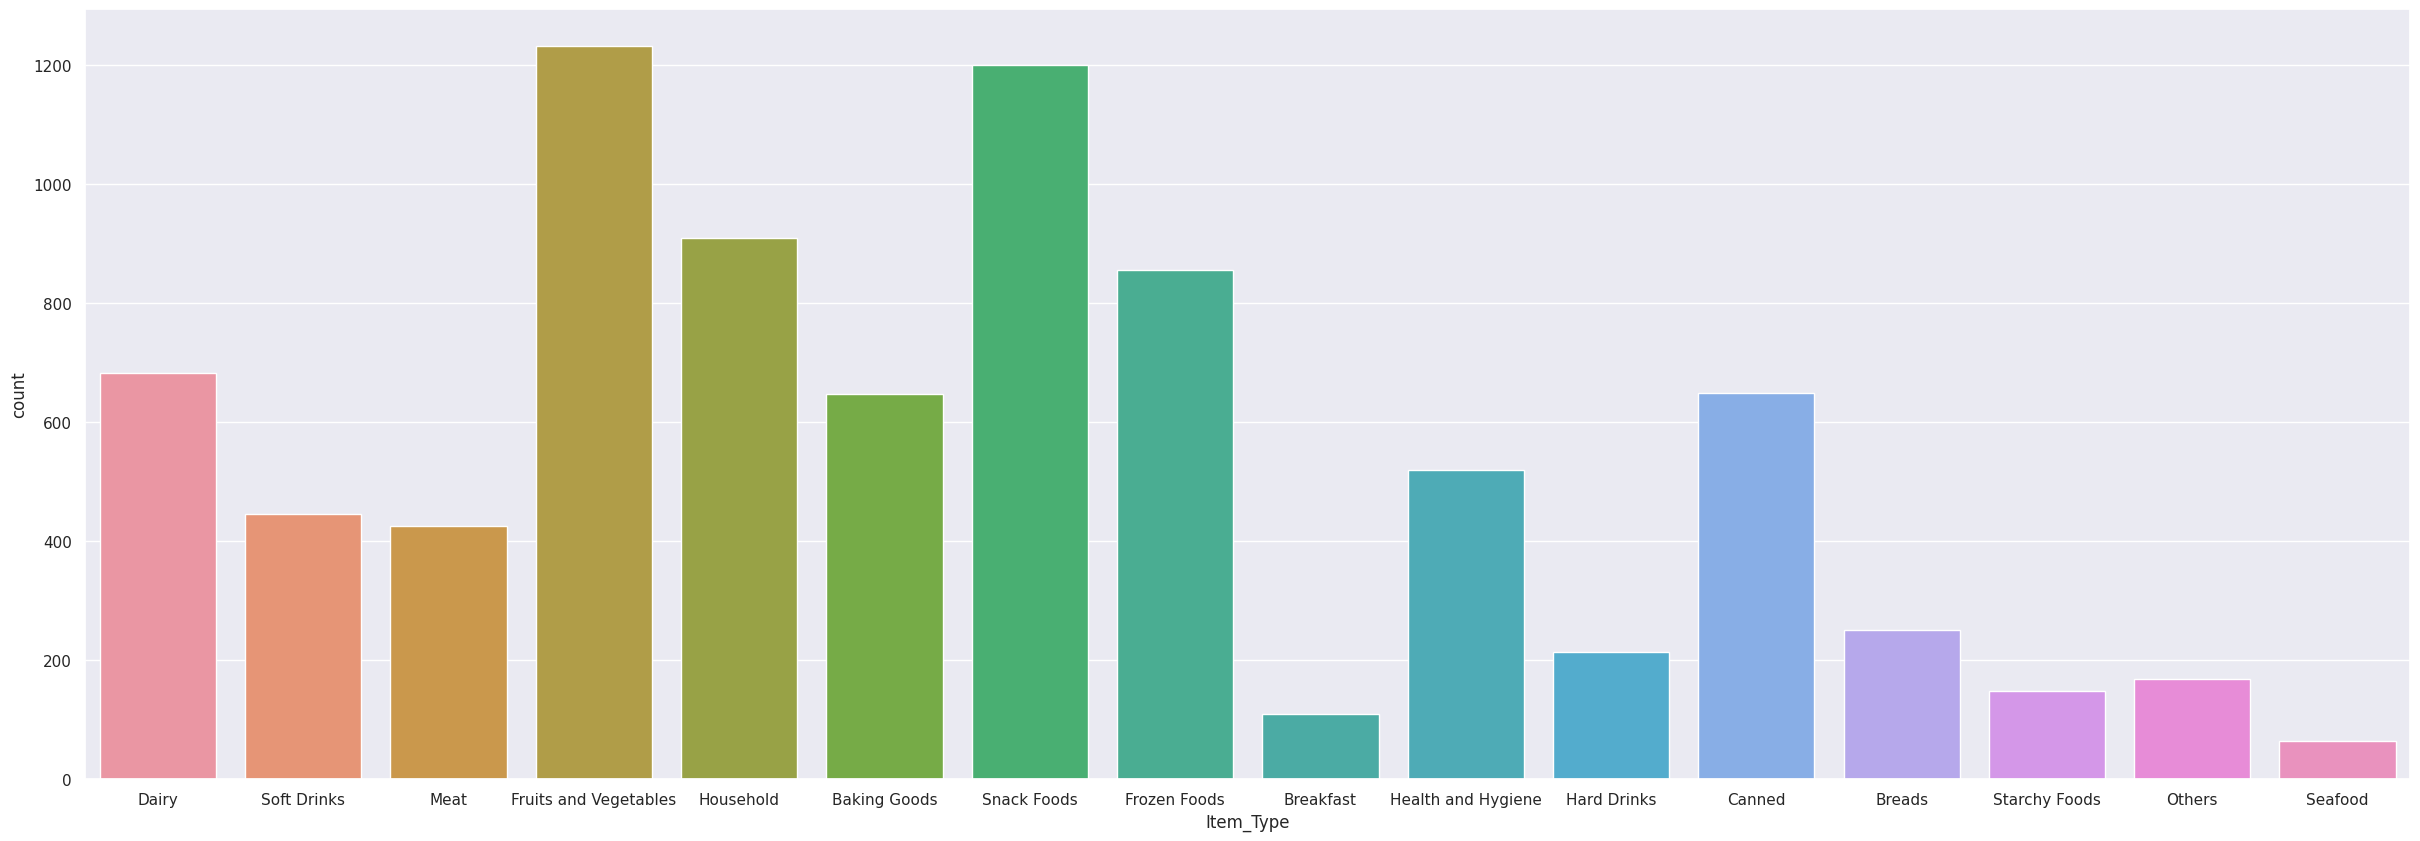

In [21]:
#Plot countplot for Item_Type column
plt.figure(figsize=(30,10))
sns.countplot(x = "Item_Type",data = df)
plt.show()

In [22]:
print(df['Outlet_Size'].head())

0                                               Medium
1                                               Medium
2                                               Medium
3    Outlet_Type Grocery Store Supermarket Type1 Su...
4                                                 High
Name: Outlet_Size, dtype: object


In [23]:
# Check for rows where Outlet_Size contains non-string or non-categorical data
nested_rows = df[df['Outlet_Size'].apply(lambda x: isinstance(x, (list, pd.DataFrame)))]
print(nested_rows)

     Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
3              FDX07       19.200          Regular         0.000000   
8              FDH17       16.200          Regular         0.016687   
9              FDU28       19.200          Regular         0.094450   
25             NCD06       13.000          Low Fat         0.099887   
28             FDE51        5.925          Regular         0.161467   
...              ...          ...              ...              ...   
8502           NCH43        8.420          Low Fat         0.070712   
8508           FDW31       11.350          Regular         0.043246   
8509           FDG45        8.100          Low Fat         0.214306   
8514           FDA01       15.000          Regular         0.054489   
8519           FDS36        8.380          Regular         0.046982   

                  Item_Type  Item_MRP Outlet_Identifier  \
3     Fruits and Vegetables  182.0950            OUT010   
8              Frozen Foods  

In [24]:
# Remove rows where Outlet_Size contains non-string/non-categorical data
df = df[~df['Outlet_Size'].apply(lambda x: isinstance(x, (list, pd.DataFrame)))]

In [25]:
df['Outlet_Size'] = df['Outlet_Size'].apply(lambda x: 'Unknown' if isinstance(x, (list, pd.DataFrame)) else x)

In [26]:
df['Outlet_Size'] = df['Outlet_Size'].astype('category')

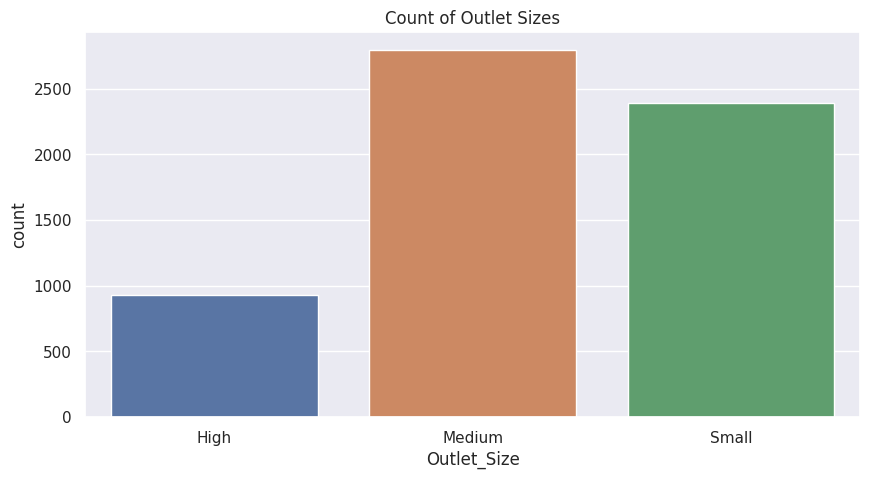

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.countplot(x="Outlet_Size", data=df)
plt.title('Count of Outlet Sizes')
plt.show()

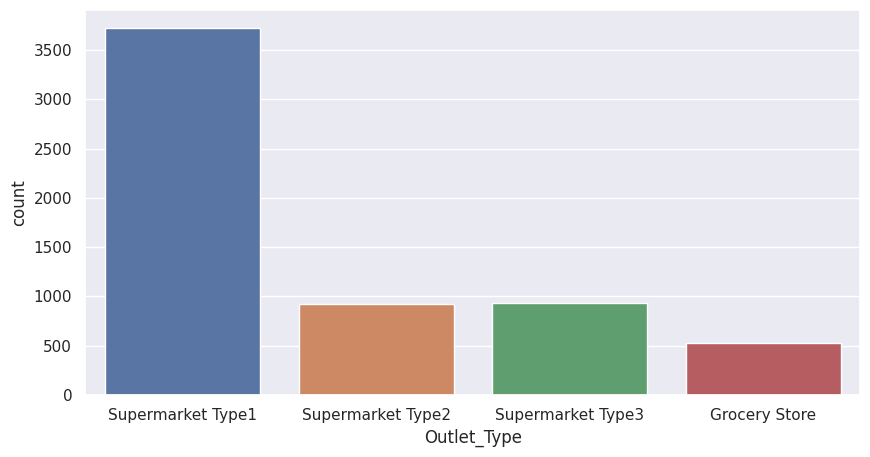

In [28]:
#Plot countplot for Outlet_Type column
plt.figure(figsize=(10,5))
sns.countplot(x= "Outlet_Type" , data=df)
plt.show()

In [29]:
#see categories in Item_Fat_Content column
df['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    3641
Regular    2076
LF          233
reg          82
low fat      81
Name: count, dtype: int64

In [30]:
#handle Item_Fat_Content column categories with replacement
df['Item_Fat_Content'].replace({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'},inplace=True)

In [31]:
df['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    3955
Regular    2158
Name: count, dtype: int64

In [32]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088


# Handle Categorical Features

In [33]:
encode = LabelEncoder()

df["Item_Identifier"] = encode.fit_transform(df["Item_Identifier"])

df["Item_Fat_Content"] = encode.fit_transform(df["Item_Fat_Content"])

df["Item_Type"] = encode.fit_transform(df["Item_Type"])

df["Outlet_Identifier"] = encode.fit_transform(df["Outlet_Identifier"])

df["Outlet_Size"] = encode.fit_transform(df["Outlet_Size"])

df["Outlet_Location_Type"] = encode.fit_transform(df["Outlet_Location_Type"])

df["Outlet_Type"] = encode.fit_transform(df["Outlet_Type"])



In [34]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,155,9.300,0,0.016047,4,249.8092,6,1999,1,0,1,3735.1380
1,8,5.920,1,0.019278,14,48.2692,1,2009,1,2,2,443.4228
2,661,17.500,0,0.016760,10,141.6180,6,1999,1,0,1,2097.2700
4,1294,8.930,0,0.000000,9,53.8614,0,1987,0,2,1,994.7052
5,757,10.395,1,0.000000,0,51.4008,1,2009,1,2,2,556.6088


# Splitting features and target

In [35]:
x = df.drop(columns = ["Item_Outlet_Sales"],axis = 1)
y = df["Item_Outlet_Sales"]

In [36]:
x

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,155,9.300,0,0.016047,4,249.8092,6,1999,1,0,1
1,8,5.920,1,0.019278,14,48.2692,1,2009,1,2,2
2,661,17.500,0,0.016760,10,141.6180,6,1999,1,0,1
4,1294,8.930,0,0.000000,9,53.8614,0,1987,0,2,1
5,757,10.395,1,0.000000,0,51.4008,1,2009,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...
8517,388,20.750,1,0.083607,5,178.8318,5,1997,2,0,1
8518,369,6.865,0,0.056783,13,214.5218,0,1987,0,2,1
8520,1354,10.600,0,0.035186,8,85.1224,4,2004,2,1,1
8521,680,7.210,1,0.145221,13,103.1332,1,2009,1,2,2


In [37]:
y

0       3735.1380
1        443.4228
2       2097.2700
4        994.7052
5        556.6088
          ...    
8517    3608.6360
8518    2778.3834
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 6113, dtype: float64

# spliting the data into training data & testing data

In [38]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 42)

# Model Training

In [39]:
regressor = XGBRegressor()
regressor.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [40]:
y_pred = regressor.predict(x_train)

In [41]:
r2_score = metrics.r2_score(y_train,y_pred)

In [42]:
print(f"R squared value: {r2_score}")

R squared value: 0.9102681220565524


# THANK YOUU :)